In [82]:
import numpy as np
from hera_cal import omni
import hera_qm.ant_metrics as ant_metrics
reload(ant_metrics)
import sys
from hera_qm import utils
import os

from __future__ import print_function, division, absolute_import
import aipy
from copy import deepcopy
from pyuvdata import UVData
import json
import re
from hera_qm.version import hera_qm_version_str

import matplotlib.pyplot as plt
%matplotlib notebook 

In [83]:
DATA_PATH = ''
o = utils.get_metrics_OptionParser('ant_metrics')

In [84]:
opt0 = "-p xx,yy,xy,yx"
opt1 = "--crossCut=5"
opt2 = "--deadCut=5"
opt3 = "--extension=.ant_metrics.json"
opt4 = "--metrics_path={}".format(os.path.join(DATA_PATH, 'test_output'))
opt5 = "--vis_format=miriad"
options = ' '.join([opt0, opt1, opt2, opt3, opt4, opt5])

In [85]:
#xx_file = os.path.join(DATA_PATH, 'zen.2458000.46582.xx.HH.uvA')
xx_file = os.path.join(DATA_PATH, 'zen.2458001.60112.xx.HH.uvA')

In [86]:
cmd = ' '.join([options, xx_file])
opts, args = o.parse_args(cmd.split())
history = cmd
# ant_metrics.ant_metrics_run(args, opts, history)

In [87]:
try:
    from hera_cal.omni import aa_to_info
    from hera_cal.utils import get_aa_from_uv
except(ImportError):
    from nose.plugins.skip import SkipTest
    raise SkipTest('hera_cal.omni not detected. It must be installed to calculate array info')

In [88]:
files = args
# check that we were given some files to process
if len(files) == 0:
    raise AssertionError('Please provide a list of visibility files')

In [89]:
# define polarizations to look for
if opts.pol == '':
    # default polarization list
    pol_list = ['xx', 'yy', 'xy', 'yx']
else:
    # assumes polarizations are passed in as comma-separated list, e.g. 'xx,xy,yx,yy'
    pol_list = opts.pol.split(',')

In [90]:
# generate a list of all files to be read in
fullpol_file_list = utils.generate_fullpol_file_list(files, pol_list)
if len(fullpol_file_list) == 0:
    raise AssertionError('Could not find all 4 polarizations for any files provided')

In [91]:
if opts.cal is not None:
    # define freqs
    # note that redundancy calculation does not depend on this, so this is just a dummy range
    freqs = np.linspace(0.1, 0.2, num=1024, endpoint=False)
    # process calfile
    aa = aipy.cal.get_aa(opts.cal, freqs)
else:
    # generate aa object from file
    # N.B.: assumes redunancy information is the same for all files passed in
    first_file = fullpol_file_list[0][0]
    uvd = UVData()
    uvd.read_miriad(first_file)
    aa = get_aa_from_uv(uvd)
    del uvd
info = aa_to_info(aa, pols=[pol_list[-1][0]])
reds = info.get_reds()

In [92]:
# do the work
for jd_list in fullpol_file_list:
    am = ant_metrics.Antenna_Metrics(jd_list, reds, fileformat=opts.vis_format)
    am.iterative_antenna_metrics_and_flagging(crossCut=opts.crossCut, deadCut=opts.deadCut,
                                              verbose=opts.verbose)

    # add history
    am.history = am.history + history

    base_filename = jd_list[0]
    abspath = os.path.abspath(base_filename)
    dirname = os.path.dirname(abspath)
    basename = os.path.basename(base_filename)
    nopol_filename = re.sub('\.{}\.'.format(pol_list[0]), '.', basename)
    if opts.metrics_path == '':
        # default path is same directory as file
        metrics_path = dirname
    else:
        metrics_path = opts.metrics_path
    metrics_basename = nopol_filename + opts.extension
    metrics_filename = os.path.join(metrics_path, metrics_basename)
    am.save_antenna_metrics(metrics_filename)

On iteration 0 we flag (69, 'x')
On iteration 1 we flag (70, 'y')
On iteration 1 we flag (70, 'x')
On iteration 2 we flag (55, 'x')
On iteration 3 we flag (51, 'y')
On iteration 3 we flag (51, 'x')
On iteration 4 we flag (69, 'y')
On iteration 5 we flag (55, 'y')
On iteration 6 we flag (67, 'x')


In [80]:
for key,val in am.allModzScores[0]['meanVij'].items():
    if key[1]=='y':
        print(key,val)

(54, 'y') 0.711488862065
(84, 'y') 1.28833095299
(25, 'y') 0.229592672959
(12, 'y') 0.295827918529
(38, 'y') -3.87429141209
(26, 'y') -0.102453984857
(52, 'y') 0.430180487991
(53, 'y') -0.208401408555
(0, 'y') -0.637511137935
(1, 'y') -0.2034693391
(40, 'y') 0.102453984857
(86, 'y') -0.885207834961
(27, 'y') -4.33632948058
(24, 'y') -1.5645853591
(41, 'y') 1.64586981228
(87, 'y') 1.8164863899


In [81]:
print(am.finalMetrics['redCorrXPol'][(67,'y')])

KeyError: (67, 'y')

In [18]:
plt.figure()
metrics = []

for key,val in am.allMetrics[0]['redCorrXPol'].items():
    if key[1]=='y':
        metrics.append(val)
plt.hist(metrics)
print(np.sum(np.array(metrics)<.1))


<IPython.core.display.Javascript object>

ValueError: max must be larger than min in range parameter.

<IPython.core.display.Javascript object>


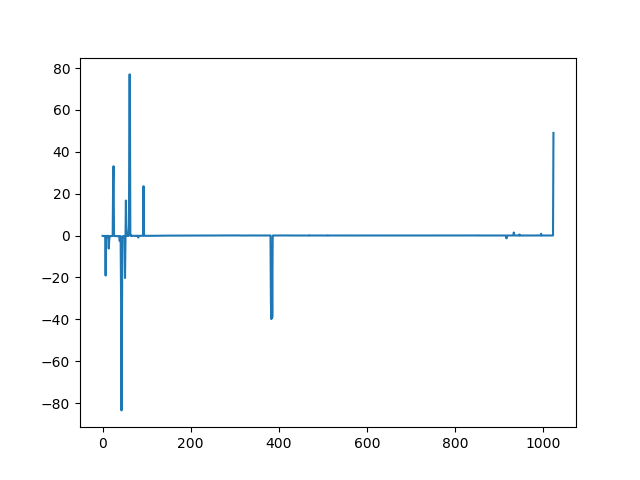

In [18]:
plt.figure()
plt.plot(np.real(am.data.get_data(0,1,'xx').T))

In [ ]:
mean_vij = ant_metrics.mean_Vij_metrics(am.data, am.pols, am.antpols, am.ants, 
                                        am.bls, xants=[], rawMetric=True)
plt.figure()
plt.hist(mean_vij.values(),50);


In [ ]:
def red_corr_metrics(data, pols, antpols, ants, reds, xants=[], rawMetric=False, crossPol=False):
    '''Calculates the extent to which baselines involving an antenna do not correlate
    with others they are nominmally redundant with.
    Arguments:
    data -- data for all polarizations in a format that can support data.get_data(i,j,pol)
    pols -- List of visibility polarizations (e.g. ['xx','xy','yx','yy']).
    antpols -- List of antenna polarizations (e.g. ['x', 'y'])
    ants -- List of all antenna indices.
    reds -- List of lists of tuples of antenna numbers that make up redundant baseline groups.
    xants -- list of antennas in the (ant,antpol) format that should be ignored.
    rawMetric -- return the raw power correlations instead of the modified z-score
    crossPol -- return results only when the two visibility polarizations differ by a single flip
    Returns:
    powerRedMetric -- a dictionary indexed by (ant,antpol) of the modified z-scores of the mean
    power correlations inside redundant baseline groups that the antenna participates in.
    Very small numbers are probably bad antennas.
    '''

    # Precompute auto-powers to save time
    autoPower = {}
    for pol in pols:
        for bls in reds:
            for (i, j) in bls:
                autoPower[i, j, pol] = np.median(np.sum(np.abs(data.get_data(i, j, pol))**2, axis=0))
    for key,val in autoPower.items():
        if val == 0: 
            print(key, data.get_data(key))
    
    return autoPower   
#     # Compute power correlations and assign them to each antenna
#     antCorrs = {(ant, antpol): 0.0 for ant in ants for antpol in antpols if
#                 (ant, antpol) not in xants}
#     antCounts = deepcopy(antCorrs)
#     for pol0 in pols:
#         for pol1 in pols:
#             iscrossed_i = (pol0[0] != pol1[0])
#             iscrossed_j = (pol0[1] != pol1[1])
#             onlyOnePolCrossed = (iscrossed_i ^ iscrossed_j)
#             # This function can instead record correlations for antennas whose counterpart are pol-swapped
#             if (not crossPol and (pol0 is pol1)) or (crossPol and onlyOnePolCrossed):
#                 for bls in reds:
#                     for n, (ant0_i, ant0_j) in enumerate(bls):
#                         data0 = data.get_data(ant0_i, ant0_j, pol0)
#                         for (ant1_i, ant1_j) in bls[n + 1:]:
#                             data1 = data.get_data(ant1_i, ant1_j, pol1)
#                             corr = np.median(np.abs(np.sum(data0 * data1.conj(),
#                                                            axis=0)))
#                             corr /= np.sqrt(autoPower[ant0_i, ant0_j, pol0] *
#                                             autoPower[ant1_i, ant1_j, pol1])
#                             antsInvolved = [(ant0_i, pol0[0]), (ant0_j, pol0[1]),
#                                             (ant1_i, pol1[0]), (ant1_j, pol1[1])]
#                             if not np.any([(ant, antpol) in xants for ant, antpol
#                                            in antsInvolved]):
#                                 # Only record the crossed antenna if i or j is crossed
#                                 if crossPol and iscrossed_i:
#                                     antsInvolved = [(ant0_i, pol0[0]),
#                                                     (ant1_i, pol1[0])]
#                                 elif crossPol and iscrossed_j:
#                                     antsInvolved = [(ant0_j, pol0[1]), (ant1_j, pol1[1])]
#                                 for ant, antpol in antsInvolved:
#                                     antCorrs[(ant, antpol)] += corr
#                                     antCounts[(ant, antpol)] += 1

#     # Compute average and return
#     for key, count in antCounts.items():
#         if count > 0:
#             antCorrs[key] /= count
#     if rawMetric:
#         return antCorrs
#     else:
#         return per_antenna_modified_z_scores(antCorrs)
    
redcorr = red_corr_metrics(am.data, am.pols, am.antpols, am.ants, am.reds, xants=[], rawMetric=True)
print(redcorr)

In [ ]:
plt.figure()
plt.plot(am.data.get_data((39, 84, 'yx')).T==0)

In [ ]:
np.sum(am.data.get_data((39, 84, 'yx'))==0)

In [ ]:
print(np.sum(am.data.data_array == 0))
print(np.sum(am.data.data_array != 0))

In [ ]:
for i in am.ants:
    test = np.zeros((len(am.ants), ))
    for j in am.ants:

[-5 -6 -7 -8]


In [ ]:
def find_totally_dead_antennas(data, ants, antposl, xants=[]):
    

In [78]:
def per_antenna_median_median_vis_sq_sum(data, ants, antpols, xants=[], log=False):
    median_vissq = {}
    for i in ants:
        for antpol_i in antpols:
            if not (i,antpol_i) in xants:
                medians = []
                for j in ants:
                    for antpol_j in antpols:
                        if not (j, antpol_j) in xants:
                            medians.append(np.median(np.sum(np.abs(data.get_data(i, j, antpol_i+antpol_j))**2, axis=0)))
                if log:
                    median_vissq[(i,antpol_i)] = np.log10(np.median(medians))
                else:
                    median_vissq[(i,antpol_i)] = np.median(medians)
    return median_vissq

xants = []
totally_dead_metrics = per_antenna_median_median_vis_sq_sum(am.data, am.ants, am.antpols, xants=xants, log=False)
for (ant,antpol), metric in totally_dead_metrics.items():
    if metric == 0:
        xants.append((ant,antpol))
print(xants)
mostly_dead_metrics = per_antenna_median_median_vis_sq_sum(am.data, am.ants, am.antpols, xants=xants, log=True)
mostly_dead_zscores = 
print('-----------------')
for item in np.abs(ant_metrics.per_antenna_modified_z_scores(totally_dead_metrics2).values()):
    print(item)

[(67, 'y'), (13, 'x'), (71, 'y'), (69, 'x'), (70, 'x'), (2, 'x'), (68, 'y'), (55, 'y'), (85, 'y'), (23, 'x'), (51, 'x'), (13, 'y'), (85, 'x'), (69, 'y'), (37, 'x'), (39, 'y'), (39, 'x'), (36, 'y'), (68, 'x'), (23, 'y'), (70, 'y'), (37, 'y'), (67, 'x'), (36, 'x'), (51, 'y'), (71, 'x'), (11, 'y'), (2, 'y'), (55, 'x')]
-----------------
0.943520187236
0.6745
0.340830035316
0.835635321
0.340830035316
1.68530281352
0.149100911798
2.03724623375
0.247685785099
0.107858178978
1.21475152419
0.200437017369
1.22225709882
0.63264624386
0.322595114941
0.589829715941
1.19746037704
0.107858178978
0.349927045434
1.06293752043
79.8177898147
0.939209280885
0.476477898679
0.513364679
0.0408558819786
1.20908113113
0.0408558819786
0.0
0.940860417958
0.909902342033
0.6745
1.18998357051
0.909902342033


In [35]:
data.get_ants()

array([ 0,  1,  2, 11, 12, 13, 23, 24, 25, 26, 27, 36, 37, 38, 39, 40, 41,
       51, 52, 53, 54, 55, 67, 68, 69, 70, 71, 84, 85, 86, 87])

In [38]:
print(data.get_data(i, j, pol).shape)

(1, 1024)


In [60]:
xants = []
autoPowers = ant_metrics.compute_median_auto_power_dict(am.data, am.pols, am.reds)

In [62]:
power_list_by_ant = {(ant,antpol): [] for ant in am.ants for antpol in am.antpols if (ant,antpol) not in xants}
for (ant0,ant1,pol),power in autoPowers.items():
    if (ant0,pol[0]) not in xants and (ant1,pol[1]) not in xants:
        power_list_by_ant[(ant0,pol[0])].append(power)
        power_list_by_ant[(ant1,pol[1])].append(power)
for (ant,antpol), power_list in power_list_by_ant.items():
    print(ant,antpol,np.median(power_list))
    if np.median(power_list) == 0:
        xants.append((ant,antpol))
print(xants)

40 x 0.000108713149989
85 x 8.82209795668e-11
86 x 9.6839790434e-05
54 y 0.000104224520333
84 y 8.27738679856e-05
25 y 0.0001106896719
12 y 0.000139648948289
24 x 0.000106130322521
38 y 7.88209243624e-05
23 x 2.36468622461e-10
26 y 9.05499770337e-05
54 x 0.000114191496178
11 x 1.1823431123e-11
84 x 6.63439029754e-05
52 y 9.13420571691e-05
12 x 0.000113550800942
37 x 3.63797878541e-11
38 x 7.91630689459e-05
26 x 9.02431796389e-05
0 y 8.78862243221e-05
52 x 8.77771509362e-05
1 x 9.21084845375e-05
53 x 0.000106987164194
27 x 9.82686802926e-05
67 x 1.81898940355e-11
39 x 2.27373675443e-11
41 x 0.00012930078651
87 x 8.8528846202e-05
1 y 0.000101036318161
40 y 9.89685792527e-05
86 y 8.06581686159e-05
0 x 7.54206321625e-05
25 x 9.86299000432e-05
27 y 8.9666085964e-05
24 y 0.000100342140865
53 y 8.52568945591e-05
41 y 0.000143875079163
87 y 0.000108462706653
55 x 4.5474731836e-12
[(67, 'y'), (13, 'x'), (71, 'y'), (69, 'x'), (70, 'x'), (2, 'x'), (68, 'y'), (55, 'y'), (85, 'y'), (51, 'x'), (13, 

In [64]:
am.data.get_data(13,51,'xx').shape

(1, 1024)